# Postprocessing

In [1]:
# Enable Jupyter Widget support for matplotlib.
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Find QMC data

The variable `dirs` is a list of all directories containing an ALF results file `data.h5`.

In [2]:
from py_alf.utils import find_sim_dirs
dirs = find_sim_dirs()
dirs

['./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_0',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_1',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_2',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_3',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_1',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_2',
 '

## Custom observables

Defining some observables derived from measurements done during the simulations (cf. {numref}`sec:pyalf-custom-obs`).

Correlation ratio 
$1 - \frac{O(\boldsymbol{k}+\boldsymbol{\delta})}{O(\boldsymbol{k})}$. RG-invariant quantity

In [3]:
def R_k(obs, back, sign, N_orb, N_tau, dtau, latt,
        ks=[(0., 0.)], mat=None, NNs=[(1, 0), (0, 1), (-1, 0), (0, -1)]):
    """RG-invariant quantity derived from a correlation function.
    
    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    if mat is None:
        mat = np.identity(N_orb, dtype=np.double)
    out = 0.
    for k in ks:
        n = latt.k_to_n(k)

        J1 = (obs[..., n].sum(axis=-1) * mat).sum()
        J2 = 0
        for NN in NNs:
            i = latt.nnlistk[n, NN[0], NN[1]]
            J2 += (obs[..., i].sum(axis=-1) * mat).sum() / len(NNs)
        out += (1 - J2/J1)

    return out / len(ks)

Binder cumulant $\left(3 - \frac{\langle s^4 \rangle}{\langle s^2 \rangle^2}\right)/2$. RG-invariant quantity

In [4]:
def binder(obs, sign, N_obs):
    return (3 - obs[2] / obs[1]**2 * sign)/2

Susceptibility $\int_{0}^{\beta}\!\text{d}\tau\, C\left(\boldsymbol{k},\tau\right)$

In [5]:
def susceptibility(obs, back, sign, N_orb, N_tau, dtau, latt,
                   ks=[[0., 0.]]):
    """Susceptibility of a time-displaced correlation function.
    
    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    out = 0.
    for k in ks:
        n = latt.k_to_n(k)
        out += dtau*obs[..., n].trace().sum() / sign
    return out / len(ks)

Fermionic single particle gap determined through a quick and dirty fit of the time-displaced Green function (cf. {numref}`sec:gap`).

In [6]:
from scipy.optimize import curve_fit

def fit_gap_lazy(obs, back, sign, N_orb, N_tau, dtau, latt):
    """Lazily fit Green function to determin gap.
    
    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    """
    i1 = (2*N_tau)//24
    i2 = (4*N_tau)//24
    green = obs[0, 0, i1:i2, :]/sign
    
    def func(x, a, b):
        return a*np.exp(-b*x)
    taus = np.arange(0., N_tau*dtau, dtau)
    res = np.empty((latt.N,), dtype=np.cdouble)
    for n in range(latt.N):
        popt, pcov = curve_fit(func, taus[i1:i2], green[:, n])
        res[n] = popt[1]
    
    return res

In [7]:
custom_obs = {}

In [8]:
# Structure factor correlation ratio
custom_obs['R_S']= {
    'needs': ['IsingZ_eq'],
    'function': R_k,
    'kwargs': {}
}

# Susceptibility correlation ratio
custom_obs['R_chi']= {
    'needs': ['IsingZT_tau'],
    'function': R_k,
    'kwargs': {}
}

# Binder cumulant
custom_obs['B']= {
    'needs': ['m_scal'],
    'function': binder,
    'kwargs': {}
}

# Susceptibility
custom_obs['chi']= {
    'needs': ['IsingZT_tau'],
    'function': susceptibility,
    'kwargs': {}
}

# Susceptibility
custom_obs['gap_lazy']= {
    'needs': ['Green_tau'],
    'function': fit_gap_lazy,
    'kwargs': {}
}

## Check warmup and autocorrelation times

C.f. {numref}`sec:pyalf-check_warmup`.

In [9]:
from py_alf import check_warmup, check_rebin

In [10]:
check_warmup(dirs, ['m_scal', 'ising_x_scal', 'chi', 'R_S', 'B', 'R_chi'],
             custom_obs=custom_obs, gui='ipy')

In [11]:
check_rebin(dirs, ['m_scal', 'ising_x_scal', 'chi', 'R_S', 'B', 'R_chi'],
            custom_obs=custom_obs, gui='ipy')

## Error analysis

The analysis results are saved in each simulation directory, both in plain text in the folder `res` and as a {mod}`pickled <pickle>` Python dictionary in the file `res.pkl`. 

Due to its length, the text printed out during the analysis is hidden, but can be viewed in the [website version](https://purl.org/diss-jschwab) of this document.

In [12]:
from py_alf.analysis import analysis
for directory in dirs:
    analysis(directory, custom_obs=custom_obs, always=True)

### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0 ###
/home/jonas/dissertation/jb/appendix_nematic/pyalf
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']
custom gap_lazy ['Green_tau']


/home/jonas/mambaforge/lib/python3.10/site-packages/numpy/lib/function_base.py:625: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau
IsingXT_tau
IsingZT_tau
### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1 ###
/home/jonas/dissertation/jb/appendix_nematic/pyalf
Custom observables:
custom R_S ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']
custom gap_lazy ['Green_tau']
Scalar observables:
Acc_Temp_scal
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau
IsingXT_tau
IsingZT_tau
### Analyzing ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0

## Read analysis results

Read all the `res.pkl` files and combine them in a single {class}`pandas DataFrame <pandas.DataFrame>`, called `res`.

In [13]:
from py_alf.ana import load_res
res = load_res(dirs)

./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_0
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_1
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_2
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_3
No orbital locations saved.
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/T

The printout of the following command is again hidden, but can be viewed in the [website version](https://purl.org/diss-jschwab) of this document.

In [14]:
res

beta  dtau  global_h  \
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  40.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  40.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  40.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  40.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  16.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  16.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  16.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  16.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  24.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  24.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  24.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  24.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  32.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  32.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  32.0   0.1       3.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...  32.0   0.1       3.0   

                                                    global_j global_type  \
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       1.0         b''   

                                                    ham_chem  ham_h  ham_j  \
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    2.5    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    3.0    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    3.5    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    4.0    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    2.5    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    3.0    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    3.5    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    4.0    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    2.5    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    3.0    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    3.5    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    4.0    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    2.5    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    3.0    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    3.5    1.0   
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...       0.0    4.0    1.0   

                                                    ham_t  ham_xi  ...  \
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1...    1.0    0.25

## Plot order parameter

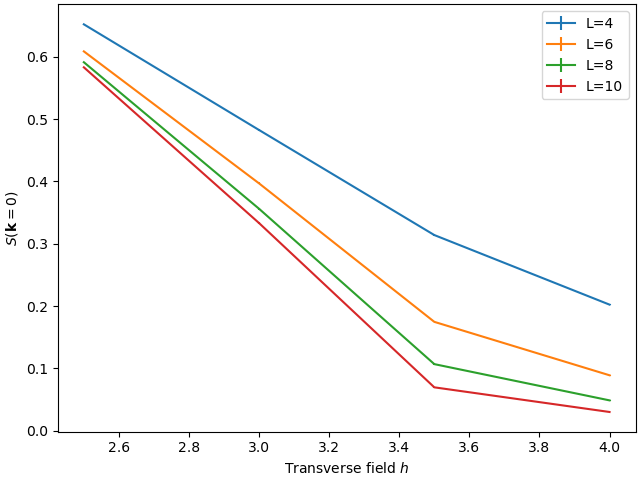

In [15]:
fig, ax = plt.subplots(constrained_layout=True)
for L in [4, 6, 8, 10]:
    df = res[res.l1 == L].sort_values(by='ham_h')
    ax.errorbar(df.ham_h, df.m_scal0, df.m_scal0_err, label=f'L={L}')
ax.legend()
ax.set_xlabel('Transverse field $h$')
ax.set_ylabel('$S(\boldsymbol{k}=0)$');

## Plot RG-invariant quantities

RG-invariant quantities behave at critical point as:

$$
R = f(L^z/\beta, (h-h_\mathrm{c})L^{1/\nu}, L^{-\omega})
$$

Dismissing dependence on $\beta$ and finite size corrections:

$$
R = f((h-h_\mathrm{c})L^{1/\nu})
$$ (eq:R)

Therefore, they should cross for different system sizes at $h = h_{\rm c}$.

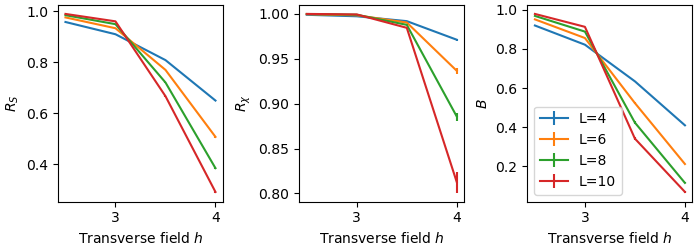

In [16]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(7, 2.5))
for L in [4, 6, 8, 10]:
    df = res[res.l1 == L].sort_values(by='ham_h')
    for obs_name, ylabel, ax in zip(['R_S', 'R_chi', 'B'],
                                    [r'$R_S$', r'$R_\chi$', r'$B$'],
                                    axs):
        ax.errorbar(
            df.ham_h, df[obs_name], df[obs_name+'_err'], label=f'L={L}')
        ax.set_xlabel('Transverse field $h$')
        ax.set_ylabel(ylabel)
ax.legend();

(app:pyalf_data_collapse)=
## Data collapse

I demonstrate here briefly how one can perform a data collapse. The amount of data is too little and the system sizes too small to get meaningful results, but the overall approach can still be presented well.

### Manual data collapse

The first step is to manually vary the parameters, in this case $h_{\rm c}$ and $a = 1/\nu$, to collapse the data. The results can then be used as starting parameters of the automatic data collapse in the next step.

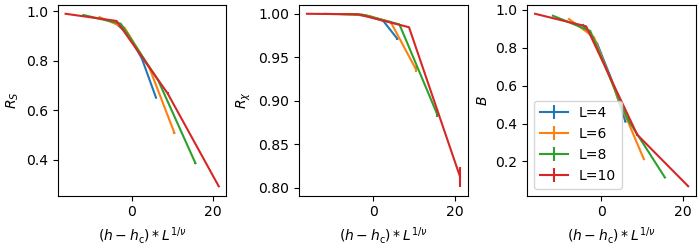

In [17]:
hc = 3.15
a = 1.4  # a=1/nu
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(7, 2.5))
for L in [4, 6, 8, 10]:
    df = res[res.l1 == L].sort_values(by='ham_h')
    for obs_name, ylabel, ax in zip(['R_S', 'R_chi', 'B'],
                                    [r'$R_S$', r'$R_\chi$', r'$B$'],
                                    axs):
        ax.errorbar((df.ham_h-hc)*L**a, df[obs_name],
                    df[obs_name+'_err'], label=f'L={L}')
        ax.set_xlabel(r'$(h-h_{\rm c})*L^{1/\nu}$')
        ax.set_ylabel(ylabel)
ax.legend();

### Data collapse fit

See {ref}`Appendix A.3<appendix_collapse_source>` for the source code of `collapse`.

In [18]:
from collapse import collapse

The function `func` defines the scaling assumption of Eq.&nbsp;{eq}`eq:R`.

In [19]:
def func(L, x, dx, y, dy, par):
    """Scaling assumption of RG-invariant quantities
    without corrections to scaling."""
    xc = par[0]
    a = par[1]  # a=1/nu 
    x_scaled = (x-xc) * L**a
    if dx is None:
        dx_scaled = None
    else:
        dx_scaled = (x-xc) * L**a
    y_scaled = y
    dy_scaled = dy
    return x_scaled, dx_scaled, y_scaled, dy_scaled

Performing automatic data collapse of $R_S$ for system sizes $L \in \{4, 6, 8, 10\}$ and starting parameters $h_{\rm c} = 3.15$, $1/\nu = 1.4$ from the manual data collapse. 

{'Ls': [4, 6, 8, 10],
 'L0': 4,
 'NL': 4,
 'popt': array([ 3.19239096e+00,  1.28013715e+00,  9.08264521e-01, -1.67682563e-02,
        -1.24065522e-03, -3.29972113e-05]),
 'perr': array([8.89780198e-03, 4.91240345e-03, 2.45520108e-03, 6.27747079e-04,
        5.22775205e-05, 1.42967090e-06]),
 'S': 1136.7062136799598}

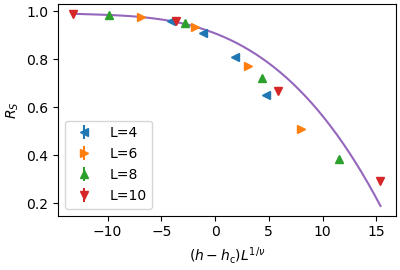

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(4, 2.7))
plt.xlabel(r'$(h-h_{\rm c})L^{1/\nu}$')
plt.ylabel(r'$R_S$')
collapse(func, 'ham_h', 'R_S', res, Ls=[4, 6, 8, 10] , par0=[3.15, 1.3])

The resulting data collapse does not look very good and the quality of fit function $S \approx 1500$, which should be of order 1, is much too big.

Some likely reasons for this are:

1. Too small system sizes.
2. Too few data points.
3. Too large fitting range, meaning to big values of $\left|(h-h_{\rm c})L^{1/\nu}\right|$.

We dismiss system sizes $L=4$ and restrict the data to $(h-h_{{\rm c},0})L^{1/\nu_0} \in [-5, 10]$. This leads to a much more agreeable, but still too large $S \approx 24$. Furthermore, there are only 6 data points left and the result $1/\nu = 1.2 \pm 0.1$ is not in agreement with {numref}`sec:nematic_qmc_results`. Nevertheless, this might be the best that can be done with the available data in terms of data collapses.

{'Ls': [6, 8, 10],
 'L0': 6,
 'NL': 3,
 'popt': array([ 3.22588756e+00,  1.22585025e+00,  8.74205610e-01, -3.71090125e-02,
        -3.65818772e-03,  2.59712699e-05]),
 'perr': array([0.04638255, 0.10616724, 0.0102565 , 0.00745803, 0.00196077,
        0.00023591]),
 'S': 26.630914312767914}

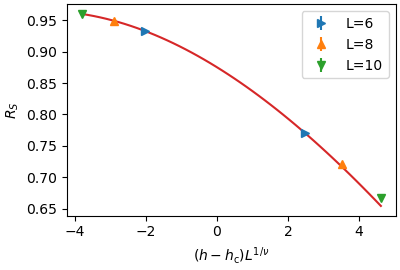

In [21]:
hc0 = 3.15
a0 = 1.3
df = res[(res['ham_h']-hc)*res.l1**a > -5]
df = df[(df['ham_h']-hc)*df.l1**a < 10]
fig = plt.figure(constrained_layout=True, figsize=(4, 2.7))
plt.xlabel(r'$(h-h_{\rm c})L^{1/\nu}$')
plt.ylabel(r'$R_S$')
collapse(func, 'ham_h', 'R_S', df, Ls=[6, 8, 10] , par0=[hc0, a0])

## Plot correlation

### Accessing elements of the dataframe

In [22]:
res.columns

Index(['beta', 'dtau', 'global_h', 'global_j', 'global_type', 'ham_chem',
       'ham_h', 'ham_j', 'ham_t', 'ham_xi',
       ...
       'IsingXT_tauK_err', 'IsingXT_tauR', 'IsingXT_tauR_err',
       'IsingXT_tau_lattice', 'IsingZT_tauK', 'IsingZT_tauK_err',
       'IsingZT_tauR', 'IsingZT_tauR_err', 'IsingZT_tau_lattice', 'lattice'],
      dtype='object', length=128)

In [23]:
res.index

Index(['./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_0',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_1',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_2',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_3',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_1',
       './ALF_data/temper_Nemati

In [24]:
item = res.loc['./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0']
item

beta                                                                40.0
dtau                                                                 0.1
global_h                                                             3.0
global_j                                                             1.0
global_type                                                          b''
                                             ...                        
IsingZT_tauK_err       [[0.0008932302580056016, 0.0011906138182334284...
IsingZT_tauR           [[0.5773744618389179, 0.5776504791744279, 0.57...
IsingZT_tauR_err       [[0.0005925670020223004, 0.000599508043614475,...
IsingZT_tau_lattice    {'L1': [7.071067811865475, 7.071067811865475],...
lattice                {'L1': [7.071067811865475, 7.071067811865475],...
Name: ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0, Length: 128, dtype: object

In [25]:
item['IsingZ_eqK']

array([[[ 0.32638655,  0.34595176,  0.37585751,  0.40512372,
          0.41848529,  0.40560553,  0.3758137 ,  0.34585338,
          0.32686855,  0.32000094,  0.34582087,  0.36959162,
          0.40548   ,  0.44284267,  0.4599152 ,  0.44257476,
          0.40533533,  0.36922645,  0.3460411 ,  0.33724708,
          0.37373131,  0.40447458,  0.45249519,  0.50672501,
          0.53239187,  0.50668498,  0.4533181 ,  0.4044087 ,
          0.37437927,  0.36392956,  0.40205248,  0.43922089,
          0.50464484,  0.58204502,  0.62283904,  0.58161175,
          0.50320508,  0.44007743,  0.40266863,  0.38967683,
          0.41550708,  0.45576157,  0.52808854,  0.6214426 ,
         58.38260793,  0.6214426 ,  0.52808854,  0.45576157,
          0.41550708,  0.40164649,  0.40266863,  0.44007743,
          0.50320508,  0.58161175,  0.62283904,  0.58204502,
          0.50464484,  0.43922089,  0.40205248,  0.38967683,
          0.37437927,  0.4044087 ,  0.4533181 ,  0.50668498,
          0.53239187,  0

### Creating Lattice object

In [26]:
from py_alf import Lattice

In [27]:
latt = Lattice(item['IsingZ_eq_lattice'])

### Spin-Spin correlation deep in ordered phase

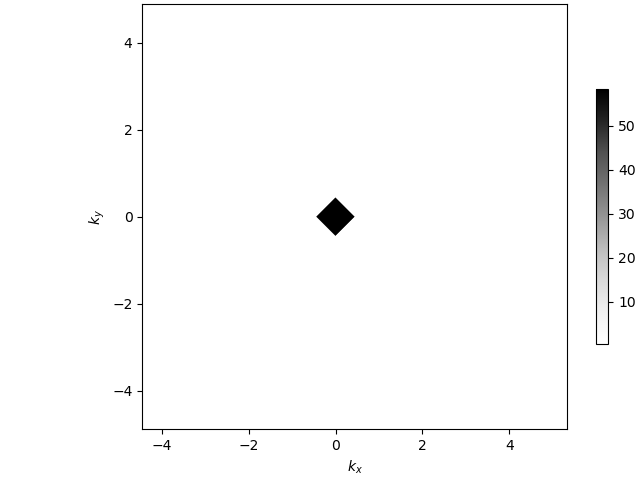

In [28]:
latt.plot_k(item['IsingZ_eqK'][0,0])

### Spin-Spin correlation in disordered phase

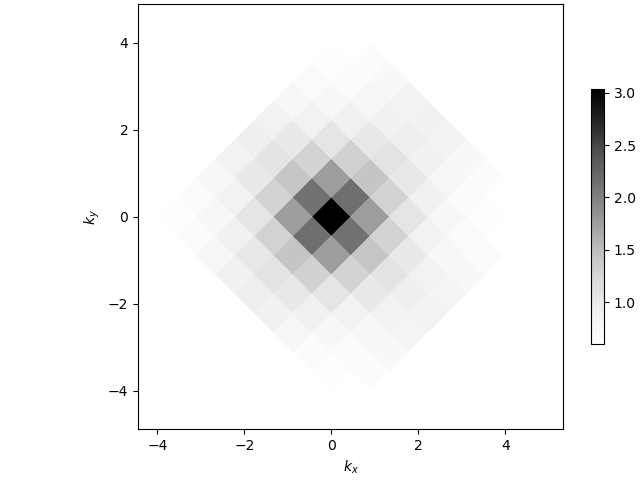

In [29]:
latt.plot_k(res.loc[
    './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3',
    'IsingZ_eqK'][0,0])

(app:pyalf_fit_green_tau)=
## Fermionic dispersion

See {ref}`Appendix A.4<app:fit_green_tau_source>` for source code of `fit_green_tau`.

In [30]:
from fit_green_tau import fit_green_tau

In [31]:
dic = {}
for i in res.index:
    print(i)
    dtau = res.loc[i, 'dtau']
    Green = res.loc[i, 'Green_tauK']
    dGreen = res.loc[i, 'Green_tauK_err']
    (N_tau, N) = Green.shape
    taus = np.arange(0., N_tau*dtau, dtau)
    dic[i] = np.empty((N, 2))
    for n in range(N):
        # print(f'{n} out of {N}')
        G = Green[:, n]
        dG = dGreen[:, n]
        dic[i][n] = fit_green_tau(taus, G, dG, plot=False)
res['gap'] = pd.Series(dic)

./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0


/home/jonas/mambaforge/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/home/jonas/mambaforge/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jonas/dissertation/jb/appendix_nematic/pyalf/fit_green_tau.py:118: RuntimeWarning: divide by zero encountered in divide
  chi_squared = np.sum(((func(x[i1:i2], *popt)-y[i1:i2])/dy[i1:i2])**2)
/home/jonas/dissertation/jb/appendix_nematic/pyalf/fit_green_tau.py:32: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)
/home/jonas/dissertation/jb/appendix_nematic/pyalf/fit_green_tau.py:35: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*(x-taus[-1]))


./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2


/home/jonas/dissertation/jb/appendix_nematic/pyalf/fit_green_tau.py:32: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*x)
/home/jonas/dissertation/jb/appendix_nematic/pyalf/fit_green_tau.py:35: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(b*(x-taus[-1]))


./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3


/home/jonas/mambaforge/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_1
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_2
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5/Temp_3
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_1
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_2
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_3
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=8_L2=8_beta=32.0_xi=0.25_h=2.5/Temp_0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=8_L2=8_beta=32.0_xi=0.25_h=2.5/Temp_1
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=8_L2=8_beta=32.0_xi=0.25_h=2.5/Temp_2
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=8_L2=8

We plot the determined dispersion for system sizes $L=10$ and mark the points $\boldsymbol{k} = (\pi/2, \pi/2)$ and $\boldsymbol{k} = (\pi/2, -\pi/2)$, which are the locations of the Dirac points in the disordered phase. One can see how the Dirac cones are displaced in the ordered phase at $h = 2.5, 3.0$, while they remain in place in the ordered phase at $h = 3.5, 4.0$. Notably, the simulation at $h = 2.5$ features $\langle \hat{s}^z \rangle < 0$ and $h = 3.0$ features $\langle \hat{s}^z \rangle > 0$ (cf. {numref}`Fig. %s(a1)<fig:dispersion>`), which is random. The displaced Dirac cones are only observable because the simulation is not fully ergodic and randomly "chooses" one of the two symmetry broken phases.

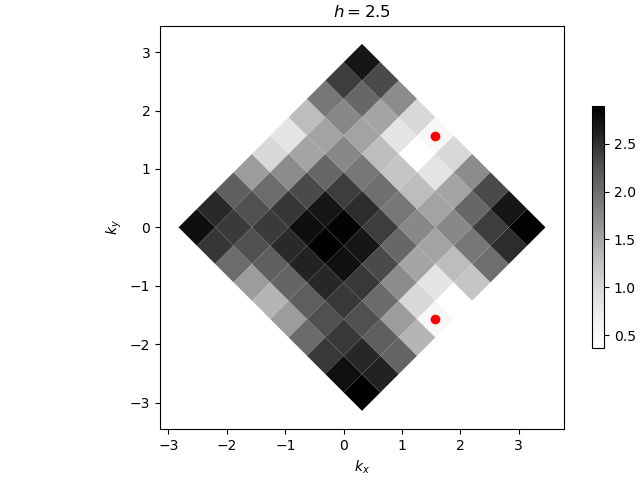

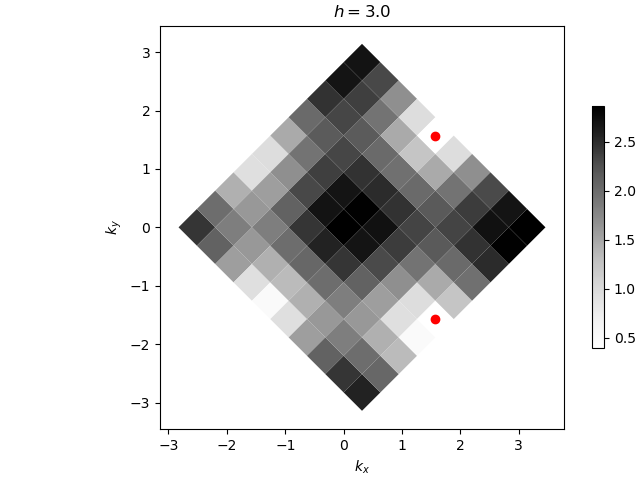

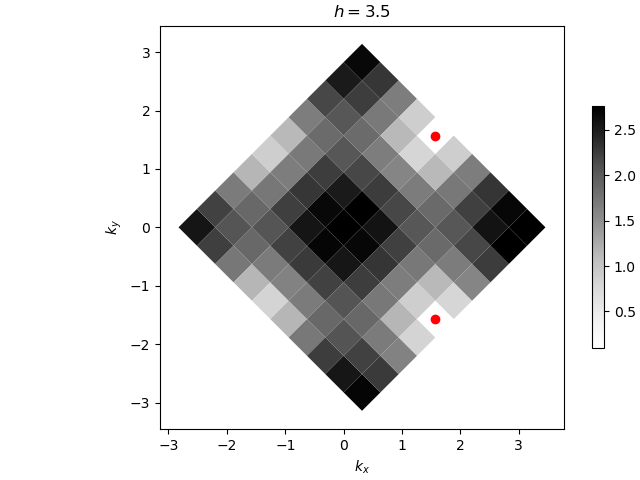

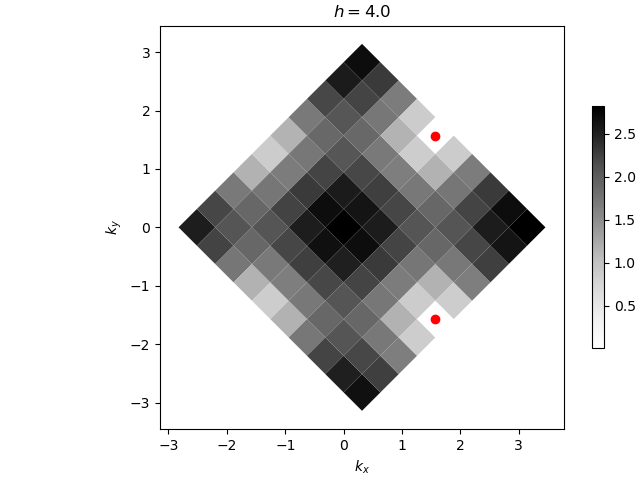

In [32]:
df = res[res.l1 == 10]
latt = Lattice([10, 10], [10, -10], [1, 1], [1, -1])
for i in df.index:
    latt.plot_k(res.loc[i, 'gap_lazy'])
    plt.title(f'$h = {res.loc[i, "ham_h"]}$')
    p = np.pi/2
    plt.plot([p, p], [p, -p], 'o', color='red')

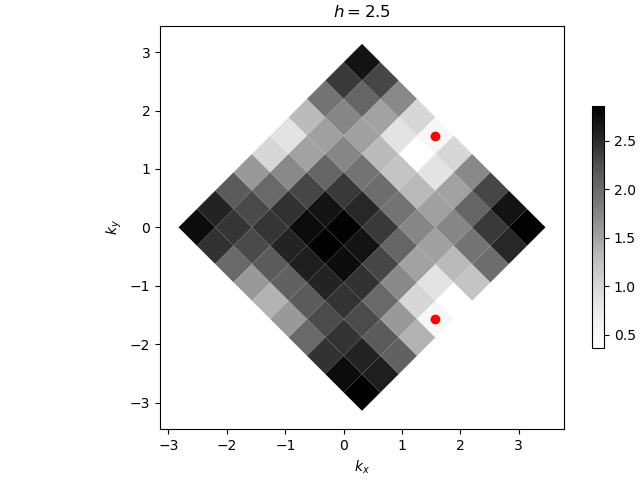

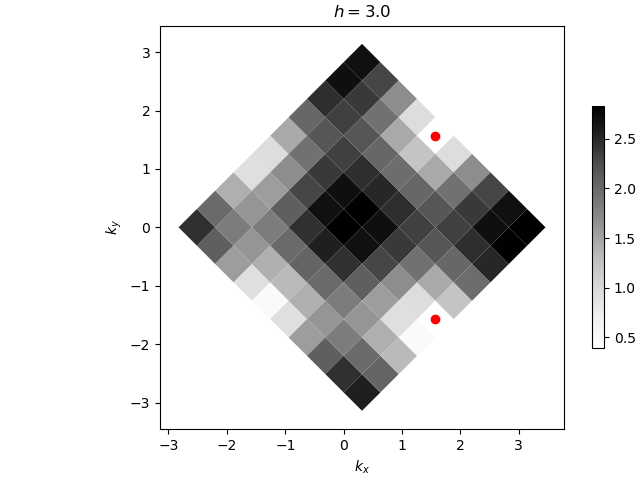

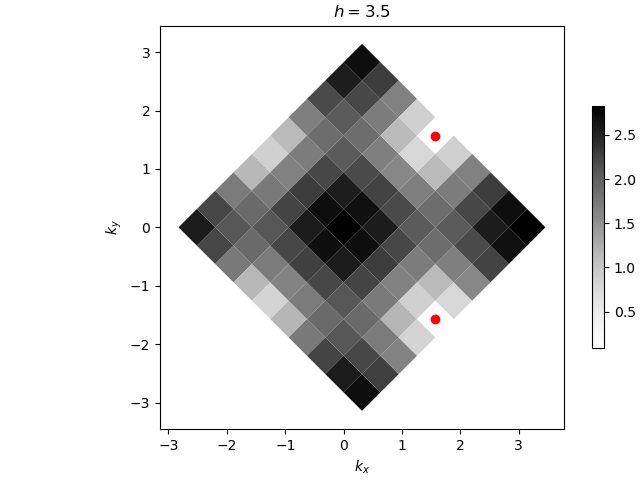

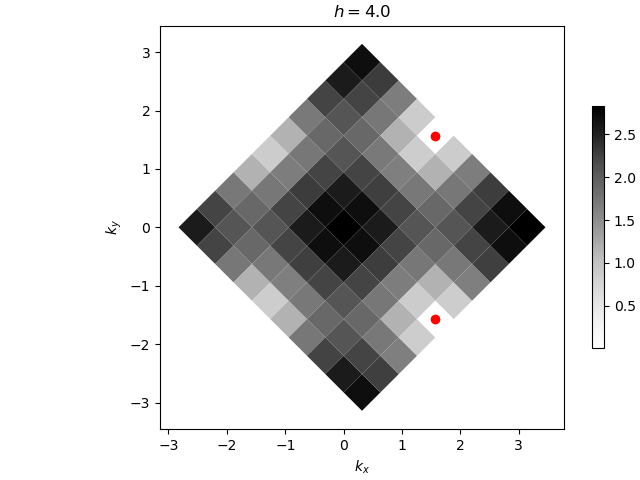

In [33]:
df = res[res.l1 == 10]
latt = Lattice([10, 10], [10, -10], [1, 1], [1, -1])
for i in df.index:
    latt.plot_k(res.loc[i, 'gap'][:, 0])
    plt.title(f'$h = {res.loc[i, "ham_h"]}$')
    p = np.pi/2
    plt.plot([p, p], [p, -p], 'o', color='red')